In [105]:
import pandas as pd
from pathlib import Path

# --- data load ---
CSV_PATH = Path("football_matches_2024_2025.csv")
assert CSV_PATH.exists(), f"CSV not found at: {CSV_PATH.resolve()}"

df = pd.read_csv(CSV_PATH)

In [106]:
# --- data cleaning & preprocessing ---
import pandas as pd
from pandas.api.types import is_string_dtype

# 1) Normalize column names (lowercase + underscores)
df.columns = (
    df.columns.str.strip().str.lower()
        .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
        .str.strip("_")
)

# 2) Basic type casting (only if columns exist)
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)

for g in ["home_goals", "away_goals"]:
    if g in df.columns:
        df[g] = pd.to_numeric(df[g], errors="coerce")

for c in ["league", "home_team", "away_team"]:
    if c in df.columns and is_string_dtype(df[c]):
        df[c] = df[c].str.strip()

# 3) Drop obvious duplicates if we have the keys
keys = [k for k in ["date", "league", "home_team", "away_team"] if k in df.columns]
if keys:
    df = df.drop_duplicates(subset=keys)

# 4) Split played / unplayed (handy later)
if {"home_goals", "away_goals"}.issubset(df.columns):
    df_played   = df.dropna(subset=["home_goals", "away_goals"]).copy()
    df_upcoming = df[df[["home_goals","away_goals"]].isna().any(axis=1)].copy()
else:
    df_played, df_upcoming = df.copy(), df.iloc[0:0].copy()

print("Done. Shape:", df.shape, "| Played:", len(df_played), "| Upcoming:", len(df_upcoming))


Done. Shape: (1929, 23) | Played: 1929 | Upcoming: 0


In [107]:
# --- Simple statistical analysis: mean, median, std, correlations ---
# 1) Keep only numeric columns
num_df = df.select_dtypes(include="number").copy()

if num_df.shape[1] == 0:
    raise ValueError("No numeric columns found. Ensure numeric fields (e.g., goals) are numeric.")

# 2) Summary stats per numeric column
# mean = average, median = 50th percentile, std = standard deviation (sample, ddof=1)
summary_stats = num_df.agg(['mean', 'median', 'std']).T.sort_index().round(3)

print("=== Summary stats (numeric columns) ===")
print(summary_stats)

# 3) Correlation matrix (Pearson)
corr_matrix = num_df.corr(method='pearson').round(3)

print("\n=== Pearson correlation matrix ===")
print(corr_matrix)

=== Summary stats (numeric columns) ===
                       mean    median       std
away_points           1.235       1.0     1.304
away_team_id        483.648     109.0  1173.014
fulltime_away         1.337       1.0     1.201
fulltime_home         1.531       1.0     1.318
goal_difference       0.194       0.0     1.875
halftime_away         0.590       0.0     0.791
halftime_home         0.698       0.5     0.860
home_points           1.525       1.0     1.331
home_team_id        483.785     109.0  1172.950
match_id         502231.883  498891.0  7285.115
matchday             17.429      17.0    11.030
total_goals           2.868       3.0     1.686

=== Pearson correlation matrix ===
                 match_id  matchday  home_team_id  away_team_id  \
match_id            1.000    -0.362         0.136         0.135   
matchday           -0.362     1.000        -0.020        -0.033   
home_team_id        0.136    -0.020         1.000         0.054   
away_team_id        0.135    -0.

In [108]:
# --- League-level stats: mean, median, std + per-league correlations ---
import pandas as pd
from pandas.api.types import is_numeric_dtype

# Basic checks
if "competition_name" not in df.columns:
    raise ValueError("Column 'competition_name' not found. Use the correct league column name.")

# Only numeric goal/score columns if possible (fallback = all numeric)
goal_like = [c for c in df.columns if ("goal" in c.lower() or "score" in c.lower()) and is_numeric_dtype(df[c])]
num_cols = goal_like if goal_like else df.select_dtypes(include="number").columns.tolist()
if not num_cols:
    raise ValueError("No numeric columns found (goals/scores).")

print("Numeric columns used for stats/correlations:", num_cols)

# Mean / median / std per league
league_stats = (
    df.groupby("competition_name")[num_cols]
        .agg(["mean", "median", "std"])
        .round(3)
)
# Flatten MultiIndex columns for readability
league_stats.columns = [f"{col}_{stat}" for col, stat in league_stats.columns]
print("=== Per-league stats (mean / median / std) ===")
print(league_stats.head(10))

# Correlation matrix per league (Pearson)
corr_by_league = {}
for lg, g in df.groupby("competition_name"):
    corr_by_league[lg] = g[num_cols].corr(method="pearson").round(3)

# league with the most matches
top_lg = df["competition_name"].value_counts().idxmax()
print(f"\n=== Pearson correlation matrix for league with the most matches: {top_lg} ===")
print(corr_by_league[top_lg])


Numeric columns used for stats/correlations: ['goal_difference', 'total_goals']
=== Per-league stats (mean / median / std) ===
                       goal_difference_mean  goal_difference_median  \
competition_name                                                      
Bundesliga                            0.127                     0.0   
La Liga                               0.287                     0.0   
Ligue 1                               0.239                     0.0   
Premier League                        0.092                     0.0   
Serie A                               0.118                     0.0   
UEFA Champions League                 0.412                     1.0   

                       goal_difference_std  total_goals_mean  \
competition_name                                               
Bundesliga                           1.935             3.134   
La Liga                              1.663             2.618   
Ligue 1                              1.970      

<Figure size 800x400 with 0 Axes>

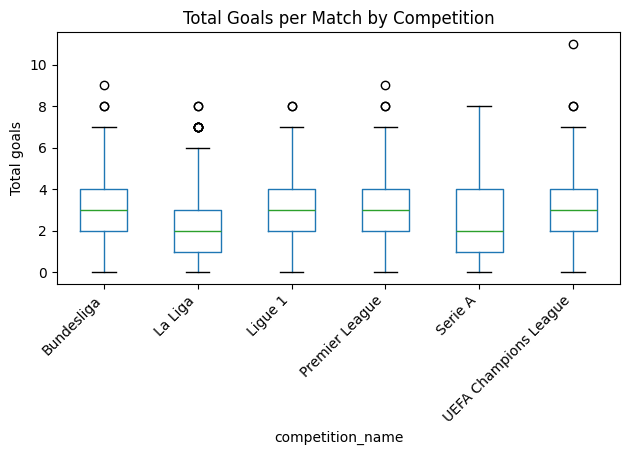

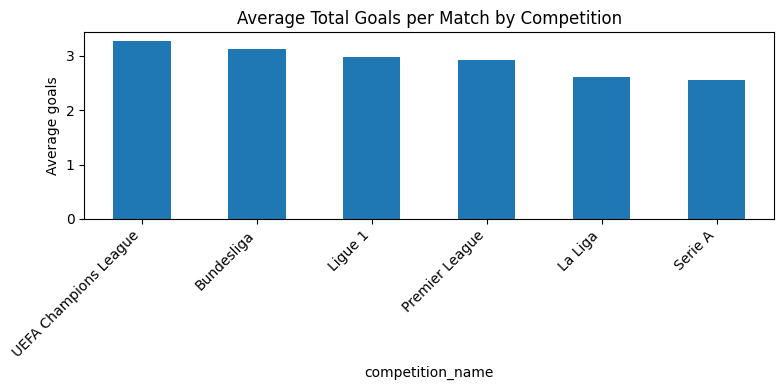

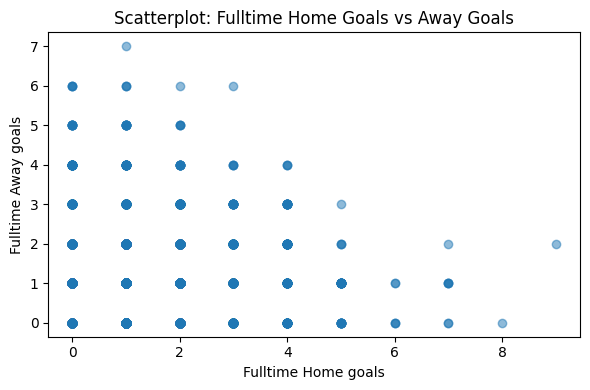

In [109]:
import matplotlib.pyplot as plt

# Distribution of total goals per competition (boxplot)
if {"competition_name","total_goals"}.issubset(df.columns):
    plt.figure(figsize=(8,4))
    df.boxplot(column="total_goals", by="competition_name", grid=False)
    plt.title("Total Goals per Match by Competition")
    plt.suptitle("")
    plt.ylabel("Total goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Average total goals per competition (bar chart)
if {"competition_name","total_goals"}.issubset(df.columns):
    plt.figure(figsize=(8,4))
    df.groupby("competition_name")["total_goals"].mean().sort_values(ascending=False).plot(kind="bar")
    plt.title("Average Total Goals per Match by Competition")
    plt.ylabel("Average goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Home vs Away goals (full time) (scatterplot)
if {"fulltime_home","fulltime_away"}.issubset(df.columns):
    plt.figure(figsize=(6,4))
    plt.scatter(df["fulltime_home"], df["fulltime_away"], alpha=0.5)
    plt.title("Scatterplot: Fulltime Home Goals vs Away Goals")
    plt.xlabel("Fulltime Home goals")
    plt.ylabel("Fulltime Away goals")
    plt.tight_layout()
    plt.show()